# USEFUL NOTES



*   Execute all cells until <font color='cyan'>TRAINING EVALUATION </font>(this one too)
*   <font color='cyan'>Confusion matrix</font> concerns the <font color='cyan'>VALIDATION SET</font>
*   At all experiments, the <font color='cyan'>table</font> which is between the confusion matrix and the learning curve of the model concerns <font color='cyan'>ONLY THE VALIDATION SET</font>
*   <font color='lightgreen'>Execute all the cells below heading FINAL MODEL</font>
*   If you want to execute the cells with the various experiments, please follow the instructions provided below (at each heading) on how to do it.
*   Please, <font color='light magenta'>DO NOT RUN </font>the <font color='light magenta'> EXPERIMENTS PART. </font> The results are already displayed, because it would be time-consuming to run.






# <font color = 'lightbrown'>LIBRARIES</font>

In [277]:
import pandas as pd
import numpy as np
import nltk
import math
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from IPython.display import Math, HTML
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import RegexpTokenizer
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import torch
import torchtext.legacy
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchtext.legacy import data

# Imports
import torch.nn.functional as F
import torch.optim as optim
import os
%matplotlib inline
import sklearn.metrics
import seaborn as sns
import random
import sys
from IPython.display import Image


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [278]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-01-30 15:36:17--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-01-30 15:36:17--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove.6B.zip.1       10%[=>                  ]  89.03M  6.75MB/s    eta 1m 49s ^C
Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.200d.txt? [y]e

In [279]:
def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

# device = 'cpu'
# print('Working on:', device)

# CONNECTION WITH GOOGLE DRIVE TO GET THE FILES

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# <font color='pink'>LOAD THE FILES (here change the name of the file)</font>
###TRAIN_SET AND VALIDATION_SET

In [280]:
cd drive/MyDrive

/content/drive/MyDrive


In [281]:
import os
path = os.getcwd()
path

'/content/drive/MyDrive'

In [282]:
#should be in the same directory with the colab notebook
file_to_be_loaded = "vaccine_train_set.csv"
file_to_be_tested = "vaccine_validation_set.csv"     #replace with the test_set.csv

In [283]:
training_df = pd.read_csv(file_to_be_loaded)
validation_df = pd.read_csv(file_to_be_tested)
training_df['cleaned tweet'] = training_df['tweet']
validation_df['cleaned tweet'] = validation_df['tweet']

In [284]:
import os
path = os.getcwd()
os.chdir('/content')
path = os.getcwd()


In [285]:
path

'/content'

# <font color='pink'>PRE-PROCESS THE DATA</font>

In [286]:
def clean(df):
  to_be_removed = ['@', '@ ', 'http', '#']
  stop_words = stopwords.words('english') 
  tokenizer = nltk.RegexpTokenizer(r"\w+")

  for row in range(len(df)):
    words_to_be_removed = set()
    r = df['cleaned tweet'].values[row].split('\n')
    r = ' '.join(r)
    r = r.split(',')
    r = ' '.join(r)
    r = r.split('.')
    r = ' '.join(r)
    r = r.split()
    r = [w.lower() for w in r]
    for word in r:
      word = word.lower()
      for item in to_be_removed:   #word has @, http
        if item in word:
          words_to_be_removed.add(word)
          break
      for w in stop_words:  #word is and, a, an, the etc
        if w == word:
          words_to_be_removed.add(word)
          break
    for word in list(words_to_be_removed):  #remove them from the data
      r = list(filter(lambda x: x != word, r)) 
    df.iloc[row, 3] = ' '.join(r)

    words_to_be_removed = set()
    r = tokenizer.tokenize(df.iloc[row, 1])   #remove all tokens
    df.iloc[row, 1] = ' '.join(r)
    r = df.iloc[row, 1].split()
    for word in r: 
      if word.isdigit():   #remove the numbers
        words_to_be_removed.add(word)
    for word in list(words_to_be_removed):
      r = list(filter(lambda x: x != word, r))
    df.iloc[row, 3] = ' '.join(r)
    if len(df.iloc[row, 3]) == 0:
      df.iloc[row, 3] = 'Fill in the empty sentence'
    
  return df

In [287]:
def Preprocess_Data(data_set, cleaning=clean):

  if cleaning:
    data_set = clean(data_set)
  df = pd.DataFrame(data_set['cleaned tweet']).to_records()
  df = [word_tokenize(tweet[1]) for tweet in df]
  data_set = df
  return data_set


In [288]:
validation_set= Preprocess_Data(validation_df)
training_set = Preprocess_Data(training_df)


# <font color='pink'>GLOVE WORD EMBEDDINGS</font>

In [289]:
file1 = 'glove.6B.50d.txt'
file2 = 'glove.6B.100d.txt'
file3 = 'glove.6B.200d.txt'    #we use this file
file4 = 'glove.6B.300d.txt'

In [290]:
def ConvertToTensor(LList, size):
  class_list = []
  for val in LList:
    val = val.tolist()
    class_list.append(val)
  classes_list = []
  for elem in class_list:
      for num in elem:
        classes_list.append(num)
  classes_tensor = torch.tensor(classes_list)
  classes_tensor = classes_tensor.view(size) 
  return classes_tensor


In [291]:
def Create_vocab_dictionary(training_data):
  vocab_dict = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "unknown_words": 3}
  for sentence in training_data:
    # sentence = sentence.split()
    for word in sentence:
      if word not in vocab_dict.keys():
        vocab_dict[word] = len(vocab_dict)
  return vocab_dict

In [292]:
def Create_embedding_dictionary(file):
  embedding_dict = {}
  with open(file, encoding='utf-8') as f:
    for line in f:
      # For each line file, the words are split and stored in a list
      values = line.split()
      word = values[0]
      vector_coef = np.asarray(values[1:], dtype='float32')
      embedding_dict[word] = vector_coef

  return embedding_dict

In [293]:
def Map_vocab_with_pretrained(vocab_dict, embed_dict):
  values = embed_dict.values()
  value_iterator = iter(values)
  first_value = next(value_iterator)
  # creating an matrix with zeroes of shape vocab x embedding dimension
  embedding_matrix = np.random.rand(len(vocab_dict), len(first_value))
  # Iterate through word, index in the dictionary
  for word, i in vocab_dict.items():
      # extract the corresponding vector for the vocab indice of same word
      embedding_vector = embed_dict.get(word)
      if embedding_vector is not None:
          # Storing it in a matrix
          embedding_matrix[i] = embedding_vector
  embedding_matrix = torch.from_numpy(embedding_matrix)
  
  return embedding_matrix

In [294]:
def Create_index2word(data_set):
  index2word = ["<PAD>", "<SOS>", "<EOS>", "unknown_words"]
  for tweet in data_set:
      for token in tweet:
          if token not in index2word:
              index2word.append(token)
  return index2word

In [295]:
def Create_word2index(index2word):
  word2index = {}
  for index, word in enumerate(index2word):
    word2index[word] = index
  return word2index

In [296]:
def Truncate_sentences(sentences, max_length):

  new_sentences = []
  for sent in sentences:
    if len(sent) > max_length:
      new_sentences.append(sent[:max_length])
    else:
      new_sentences.append(sent)

  return new_sentences

In [297]:
def Encode_sentences(sentences, word2index_dict):

  j=0
  encoded_sentences = []
  for sentence in sentences:
    encoded_sentence = []
    for i in range(len(sentence)):
      word = sentence[i]
      if word in word2index_dict.keys():
        encoded_sentence.append(word2index_dict[word])
      else:
        encoded_sentence.append(word2index_dict['unknown_words'])
    encoded_sentence = torch.tensor(encoded_sentence)
    encoded_sentences.append(encoded_sentence)
    j+=1
  print(j)
  return encoded_sentences



In [298]:
vocab_dict = Create_vocab_dictionary(training_set)   #vocabulary from the training set
print(len(vocab_dict))
embedding_dict = Create_embedding_dictionary(file3)  #dictionary with pre-trained embeddings
print(len(embedding_dict))

37902
400000


In [299]:
embedding_weights = Map_vocab_with_pretrained(vocab_dict, embedding_dict)
embedding_weights[6]

tensor([0.1960, 0.0387, 0.6159, 0.5646, 0.1082, 0.7416, 0.1835, 0.3486, 0.4805,
        0.6439, 0.6216, 0.7612, 0.2867, 0.4924, 0.6819, 0.5100, 0.7682, 0.2999,
        0.5469, 0.2446, 0.4436, 0.8100, 0.1039, 0.2300, 0.7918, 0.5665, 0.8274,
        0.9749, 0.9652, 0.9497, 0.5518, 0.0925, 0.7404, 0.5643, 0.7459, 0.4554,
        0.1557, 0.9960, 0.8897, 0.8037, 0.4115, 0.2132, 0.2944, 0.6229, 0.2482,
        0.7997, 0.0189, 0.4804, 0.7340, 0.6836, 0.4213, 0.6932, 0.3672, 0.2324,
        0.7851, 0.7267, 0.7065, 0.0317, 0.2394, 0.3711, 0.5819, 0.0880, 0.2321,
        0.8125, 0.7527, 0.8048, 0.2944, 0.7806, 0.2248, 0.2898, 0.8490, 0.7442,
        0.3323, 0.5673, 0.6996, 0.0919, 0.0538, 0.8628, 0.6300, 0.8697, 0.0877,
        0.8659, 0.0412, 0.9582, 0.2274, 0.7519, 0.4007, 0.4031, 0.2533, 0.5068,
        0.1846, 0.0571, 0.3669, 0.7198, 0.4742, 0.9226, 0.1701, 0.7184, 0.8698,
        0.1293, 0.9741, 0.7542, 0.9167, 0.0377, 0.2858, 0.8229, 0.2747, 0.0517,
        0.1479, 0.0165, 0.7824, 0.3491, 

In [300]:
# create a list with all the words in tweets
index_to_word = Create_index2word(training_set)
#Replace each word with its position index in the above list
word_to_index = Create_word2index(index_to_word)


In [301]:
train_encoded_sentences = Encode_sentences(training_set, word_to_index)
valid_encoded_sentences = Encode_sentences(validation_set, word_to_index)

15976
2282


# <font color='cyan'>Functions for METRICS</font>

In [302]:
def Learning_Curve(n_epochs, train_loss, valid_loss):  #create the learning curve
  plt.plot(n_epochs, train_loss, 'm')
  plt.plot(n_epochs, valid_loss, 'c')
  plt.title("Learning Curve")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(["training", "validation"], loc ="upper right")
  plt.show()
  return

In [303]:
def ROC_Curve(y_true, y_pred):
  fp = {}
  tp = {}
  thresh ={}

  classes = 3

  for i in range(classes):    
      fp[i], tp[i], thresh[i] = roc_curve(y_true.detach().numpy(), y_pred[:,i].detach().numpy(), pos_label=i)
  # plotting    
  plt.plot(fp[0], tp[0], color='m', label='Class 0 vs Rest')
  plt.plot(fp[1], tp[1], color='c', label='Class 1 vs Rest')
  plt.plot(fp[2], tp[2], color='b', label='Class 2 vs Rest')
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc='lower right')
  plt.show()
  return

In [304]:
def calculate_metrics(y_true, y_pred, y_pred_class):

  y_true1 = y_true.view(y_true.shape[0])
  y_valid_class = y_true1.tolist()
  classes = ['class 0', 'class 1', 'class 2']
  print(classification_report(y_valid_class, y_pred_class, target_names=classes, zero_division = 0))
  print("Precision score:\t", precision_score(y_true,y_pred.argmax(1), average = 'macro'))
  print("Recall score:\t\t", recall_score(y_true,y_pred.argmax(1), average = 'macro'))
  print("F1 score:\t\t", f1_score(y_true,y_pred.argmax(1), average = 'macro'))
  return

# <font color='greenyellow'>Create a Recurrent Neural Network - RNN</font>


In [305]:
class RNN(nn.Module):
    
    def __init__(self, input_size, num_hidden, num_classes, embedding_weights, embedding_dimension,
                 num_stacked_layers = 1, cell_type='LSTM', dropout_prob = 0.2, skip_connections = False):
        super(RNN, self).__init__()
        if num_classes is not None:
          self.cell_type = cell_type
          self.num_stacked_layers = num_stacked_layers
          self.num_hidden = num_hidden
          self.vocab_size = input_size
          self.dropout_prob = dropout_prob
          self.out_layer = nn.Linear(num_hidden*2, num_classes)
          self.embedding = nn.Embedding(input_size, embedding_dimension, padding_idx = 0)
        if skip_connections is True:
          self.skip_connections = True
        else:
          self.skip_connections = False

        if (embedding_weights is not None):
          self.embedding = self.embedding.from_pretrained(embedding_weights, freeze= True, padding_idx=0)

        if dropout_prob > 0.0:
          self.dropout = nn.Dropout(self.dropout_prob)
        if (cell_type == 'LSTM'):   
          self.rnn = nn.LSTM(embedding_dimension, num_hidden, num_stacked_layers, batch_first = True, bidirectional=True)  # (200 64 2)
        elif (cell_type == 'GRU'):
          self.rnn = nn.GRU(embedding_dimension, num_hidden, num_stacked_layers, batch_first = True, bidirectional=True)  # (200 64 2)



  
    def forward(self, sentence_sequence, hidden):
      embedded_sequence = self.embedding(sentence_sequence)
      # Dropout Layer
      if self.dropout_prob > 0.0: 
        embedded_sequence = self.dropout(embedded_sequence)

      if (self.cell_type == 'LSTM'):
        h0 = hidden[0]
        c0 = hidden[1]
        output, h = self.rnn(embedded_sequence.float(), hidden)   #input = 2*self.num_layers, batchsize, self.num_hidden, h0
      elif (self.cell_type == 'GRU'):
        h0 = hidden
        output, h = self.rnn(embedded_sequence.float(), h0)   #input = 2*self.num_layers, batchsize, self.num_hidden, h0
        
      # output -> (batch, seqlen, hidden size)
      # we want (batch, hidden size)
      output_padded = output
      output_padded = output_padded[:, -1, :]
      #output_padded -> (batch, hidden size)
      output_padded = self.out_layer(output_padded)
      output = output_padded
      return output, h



    #Initialize hidden (and cell state if cell_type is LSTM)
    def init_hidden(self, batch_size):
      if (self.cell_type == 'LSTM'):
        h0 = torch.zeros(2*self.num_stacked_layers, batch_size, self.num_hidden)
        c0 = torch.zeros(2*self.num_stacked_layers, batch_size, self.num_hidden)
        hidden = (h0, c0)
      elif (self.cell_type == 'GRU'):
        h0 = torch.zeros(2*self.num_stacked_layers, batch_size, self.num_hidden)
        hidden = h0
      return hidden



In [306]:
#Truncate the sentences to maximum 25 words
train_cut_encoded_sentences = Truncate_sentences(train_encoded_sentences, 25)
valid_cut_encoded_sentences = Truncate_sentences(valid_encoded_sentences, 25)
train_seq = train_cut_encoded_sentences  #list of tensors with diff dimensions
valid_seq = valid_cut_encoded_sentences

def InitializeDataloader(x_data, y_data, batch_size):
  
  #Separate features and targets and save in tensors
  sequence = x_data
  target = y_data
  #Pad the sequence
  padded_sentences = torch.nn.utils.rnn.pad_sequence(sequence, batch_first=True, padding_value=0)
  sentences_lengths = torch.LongTensor(list(map(len,sequence)))
  x = padded_sentences
  y_df = pd.DataFrame(target)
  y = torch.tensor(y_df.values)

  #Initialize dataloader
  dataset = torch.utils.data.TensorDataset(x, y)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

  return dataloader, sentences_lengths

# <font color='orange'>TRAINING EVALUATION </font>

In [307]:
def train(model, dataloader, batch_size, loss_func, optimizer):    #otan kalestei ->target auto training_df['label']
  
  model.train()
  batch_losses = []
  i = 0
  hidden = model.init_hidden(batch_size)
  for x_train_batch, y_train_batch in dataloader:

    if model.cell_type == 'LSTM':
      hidden = tuple([each.data for each in hidden])
    elif model.cell_type == 'GRU':
      hidden.detach_()
      hidden = hidden.detach()
    #Delete previously stored gradients
    optimizer.zero_grad()
    with torch.set_grad_enabled(True):
      if (model.cell_type == 'LSTM'):
        h0 = hidden[0]
        c0 = hidden[1]
      elif (model.cell_type == 'GRU'):
        h0 = hidden
      if( h0.size(dim=1) != x_train_batch.size(dim=0)):
        hidden = model.init_hidden(x_train_batch.size(dim=0))

      y_train_pred, hidden = model(x_train_batch, hidden)
      train_prob = nn.Softmax(dim=1)(y_train_pred)
      y_train_pred_class = torch.argmax(train_prob, dim=1)
      
      #calculate loss
      loss = loss_func(y_train_pred, y_train_batch.squeeze())
      batch_losses.append(loss.item())
      #Perform backpropagation starting from the loss calculated in this epoch
      loss.backward()
      #Gradient clip
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      #Update model's weights based on the gradients calculated during backprop
      optimizer.step()
      i+=1

  epoch_loss = sum(batch_losses) / len(dataloader)
  return epoch_loss




def evaluate(model, dataloader, batch_size, loss_func):
    
    y_valid_pred_class = []
    y_valid_predictions = []
    model.eval()
    batch_losses = []
    i = 0
    hidden = model.init_hidden(batch_size)

    for x_valid_batch, y_valid_batch in dataloader:
      with torch.no_grad():
        if(hidden[0].size(dim=1) != x_valid_batch.size(dim=0)):
          hidden = model.init_hidden(x_valid_batch.size(dim=0))
        #evaluate
        y_valid_pred, hidden = model(x_valid_batch, hidden)
        valid_prob = nn.Softmax(dim=1)(y_valid_pred)
        #get predicted class
        pred_class = torch.argmax(valid_prob, dim=1)
        y_valid_pred_class.append(pred_class)
        y_valid_predictions.append(y_valid_pred)
        #calculate loss
        loss = loss_func(y_valid_pred, y_valid_batch.squeeze())
        batch_losses.append(loss.item())
        i+=1
    
    epoch_loss = sum(batch_losses) / len(dataloader)
    return epoch_loss, y_valid_pred_class, y_valid_predictions

In [308]:
def Train_Evaluate_TheModel(model, epochs, batch_size, loss_function, optimizer, training_seq, training_target, valid_seq, valid_target):
  
  train_epoch_losses = []
  valid_epoch_losses = []
  train_dataloader, train_seq_lens = InitializeDataloader(training_seq, training_target, batch_size)  #Training set
  valid_dataloader, valid_seq_lens = InitializeDataloader(valid_seq, valid_target, batch_size)        #Validation set
  
  for epoch in range(epochs):
    train_loss = train(model, train_dataloader, batch_size, loss_function, optimizer)
    eval_loss, y_valid_pred_class, y_valid_predictions = evaluate(model, valid_dataloader, batch_size, loss_function)
    
    train_epoch_losses.append(train_loss)
    valid_epoch_losses.append(eval_loss)

    print(f"Epoch {epoch:3}: Training Loss = {train_loss:.5f}")
    print(f"Epoch {epoch:3}: Validation Loss = {eval_loss:.5f}")


  return train_epoch_losses, valid_epoch_losses, y_valid_pred_class, y_valid_predictions

# <b><font color='red'>BEST MODELS</font></b>

## <font color='magenta'>RUN THE LSTM MODEL</font>

In [ ]:
num_hidden = 64  #bigger overfits 
num_classes = 3
learning_rate = 0.0005
num_stacked_layers = 3 #maybe increase
input_size = embedding_weights.shape[0]    #size of the vocab of the trainign set
embedding_dimension = embedding_weights.shape[1]

# 32437, 200, 3, [32437, 200], 200, 2
lstm_model = RNN(input_size, num_hidden, num_classes, embedding_weights, embedding_dimension, num_stacked_layers)
loss_function = nn.CrossEntropyLoss()
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.0004, weight_decay=1e-4)

#TRAIN AND EVALUATE THE MODEL
train_epoch_losses, valid_epoch_losses, y_valid_pred_class, y_valid_predictions = Train_Evaluate_TheModel(lstm_model, 10, 32, 
                                                                                                          loss_function, lstm_optimizer,
                                                                                                          train_seq, training_df['label'],
                                                                                                          valid_seq, validation_df['label'])

Epoch   0: Training Loss = 0.92521
Epoch   0: Validation Loss = 0.85532
Epoch   1: Training Loss = 0.84390
Epoch   1: Validation Loss = 0.81904
Epoch   2: Training Loss = 0.81082
Epoch   2: Validation Loss = 0.79580
Epoch   3: Training Loss = 0.78805
Epoch   3: Validation Loss = 0.77739
Epoch   4: Training Loss = 0.77005
Epoch   4: Validation Loss = 0.76673
Epoch   5: Training Loss = 0.75200
Epoch   5: Validation Loss = 0.74789
Epoch   6: Training Loss = 0.73917
Epoch   6: Validation Loss = 0.73910
Epoch   7: Training Loss = 0.72415
Epoch   7: Validation Loss = 0.73718
Epoch   8: Training Loss = 0.70670
Epoch   8: Validation Loss = 0.73040
Epoch   9: Training Loss = 0.69465
Epoch   9: Validation Loss = 0.73277


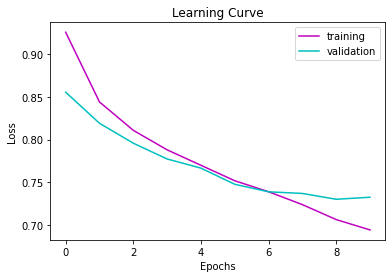

In [ ]:
epochs = np.arange(0, 10).tolist()
Learning_Curve(epochs, train_epoch_losses, valid_epoch_losses)

In [ ]:
y_training_df = pd.DataFrame(training_df['label'])
y_validation_df = pd.DataFrame(validation_df['label'])
y_train = torch.tensor(y_training_df.values)
y_valid = torch.tensor(y_validation_df.values)
y_valid_predicted_classes = ConvertToTensor(y_valid_pred_class, y_valid.shape)
y_valid_predictions = ConvertToTensor(y_valid_predictions, (y_valid.shape[0], num_classes))


In [ ]:
calculate_metrics(y_valid, y_valid_predictions, y_valid_predicted_classes)

              precision    recall  f1-score   support

     class 0       0.77      0.74      0.76      1065
     class 1       0.46      0.28      0.35       296
     class 2       0.64      0.74      0.69       921

    accuracy                           0.68      2282
   macro avg       0.62      0.59      0.60      2282
weighted avg       0.68      0.68      0.68      2282

Precision score:	 0.6246287312358448
Recall score:		 0.5907138362843276
F1 score:		 0.5990088055225223


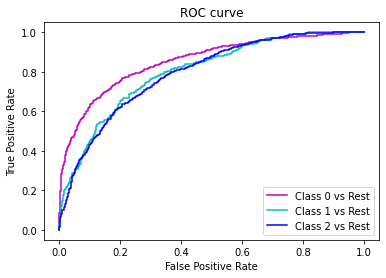

In [ ]:
ROC_Curve(y_valid, y_valid_predictions)

## <font color='magenta'>RUN THE GRU MODEL (the best)</font>

In [229]:
num_hidden = 64  #bigger overfits 
num_classes = 3
learning_rate = 0.0004
num_stacked_layers = 2 #maybe increase
input_size = embedding_weights.shape[0]    #size of the vocab of the trainign set
embedding_dimension = embedding_weights.shape[1]

# 28.921, 100, 3, [32437, 200], 200, 2
gru_model = RNN(input_size, num_hidden, num_classes, embedding_weights, embedding_dimension, num_stacked_layers, cell_type='GRU')
loss_function = nn.CrossEntropyLoss()
gru_optimizer = optim.Adam(gru_model.parameters(), lr=0.0003, weight_decay=1e-4)

#TRAIN AND EVALUATE THE MODEL
train_epoch_losses, valid_epoch_losses, y_valid_pred_class, y_valid_predictions = Train_Evaluate_TheModel(gru_model, 10, 32, 
                                                                                                          loss_function, gru_optimizer, 
                                                                                                          train_seq, training_df['label'],
                                                                                                          valid_seq, validation_df['label'])

Epoch   0: Training Loss = 0.93190
Epoch   0: Validation Loss = 0.86015
Epoch   1: Training Loss = 0.84142
Epoch   1: Validation Loss = 0.81217
Epoch   2: Training Loss = 0.80849
Epoch   2: Validation Loss = 0.78384
Epoch   3: Training Loss = 0.78718
Epoch   3: Validation Loss = 0.76784
Epoch   4: Training Loss = 0.76790
Epoch   4: Validation Loss = 0.75653
Epoch   5: Training Loss = 0.75317
Epoch   5: Validation Loss = 0.74762
Epoch   6: Training Loss = 0.73976
Epoch   6: Validation Loss = 0.73685
Epoch   7: Training Loss = 0.72447
Epoch   7: Validation Loss = 0.72993
Epoch   8: Training Loss = 0.71341
Epoch   8: Validation Loss = 0.72118
Epoch   9: Training Loss = 0.70131
Epoch   9: Validation Loss = 0.71393


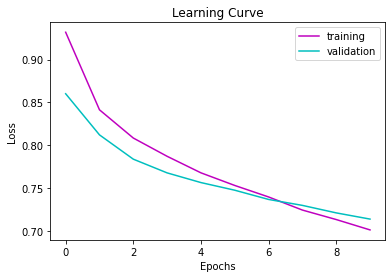

In [230]:
epochs = np.arange(0, 10).tolist()
Learning_Curve(epochs, train_epoch_losses, valid_epoch_losses)

In [231]:
y_training_df = pd.DataFrame(training_df['label'])
y_validation_df = pd.DataFrame(validation_df['label'])
y_train = torch.tensor(y_training_df.values)
y_valid = torch.tensor(y_validation_df.values)
y_valid_predicted_classes = ConvertToTensor(y_valid_pred_class, y_valid.shape)
y_valid_predictions = ConvertToTensor(y_valid_predictions, (y_valid.shape[0], num_classes))


In [232]:
calculate_metrics(y_valid, y_valid_predictions, y_valid_predicted_classes)

              precision    recall  f1-score   support

     class 0       0.75      0.77      0.76      1065
     class 1       0.50      0.31      0.38       296
     class 2       0.65      0.72      0.68       921

    accuracy                           0.69      2282
   macro avg       0.64      0.60      0.61      2282
weighted avg       0.68      0.69      0.68      2282

Precision score:	 0.6360439720442632
Recall score:		 0.5994873388780807
F1 score:		 0.6098935077268514


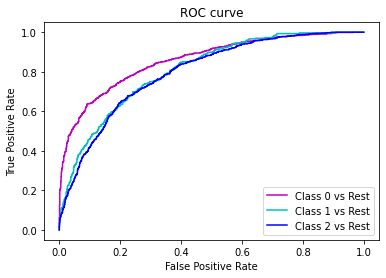

In [233]:
ROC_Curve(y_valid, y_valid_predictions)

# <font color='light magenta'>EXPERIMENTS</font>

### <font color='white'>At each set of cells, different combinations of hyper parameters are tested and the corresponding results are presented (Learning Curves - ROC Curve - Classification Report)</font>

## <font color='purple'>LSTM</font>

### <font color='purple'>1</font>

In [217]:
#Truncate the sentences to maximum 20 words
train_cut_encoded_sentences = Truncate_sentences(train_encoded_sentences, 20)
valid_cut_encoded_sentences = Truncate_sentences(valid_encoded_sentences, 20)
train_seq = train_cut_encoded_sentences  #list of tensors with diff dimensions
valid_seq = valid_cut_encoded_sentences

def InitializeDataloader(x_data, y_data, batch_size):
  
  #Separate features and targets and save in tensors
  sequence = x_data
  target = y_data
  #Pad the sequence
  padded_sentences = torch.nn.utils.rnn.pad_sequence(sequence, batch_first=True, padding_value=0)
  sentences_lengths = torch.LongTensor(list(map(len,sequence)))
  x = padded_sentences
  y_df = pd.DataFrame(target)
  y = torch.tensor(y_df.values)

  #Initialize dataloader
  dataset = torch.utils.data.TensorDataset(x, y)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

  return dataloader, sentences_lengths

In [218]:
num_hidden = 128  #bigger overfits 
num_classes = 3
learning_rate = 0.0005
num_stacked_layers = 4 #maybe increase
input_size = embedding_weights.shape[0]    #size of the vocab of the trainign set
embedding_dimension = embedding_weights.shape[1]

# 28.921, 200, 3, [32437, 200], 200, 4
lstm_model = RNN(input_size, num_hidden, num_classes, embedding_weights, embedding_dimension, num_stacked_layers)
loss_function = nn.CrossEntropyLoss()
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.0003, weight_decay=1e-4)

#TRAIN AND EVALUATE THE MODEL
train_epoch_losses, valid_epoch_losses, y_valid_pred_class, y_valid_predictions = Train_Evaluate_TheModel(lstm_model, 10, 64, 
                                                                                                          loss_function, lstm_optimizer,
                                                                                                          train_seq, training_df['label'],
                                                                                                          valid_seq, validation_df['label'])

Epoch   0: Training Loss = 0.93774
Epoch   0: Validation Loss = 0.88932
Epoch   1: Training Loss = 0.85566
Epoch   1: Validation Loss = 0.83217
Epoch   2: Training Loss = 0.82956
Epoch   2: Validation Loss = 0.80698
Epoch   3: Training Loss = 0.80542
Epoch   3: Validation Loss = 0.79022
Epoch   4: Training Loss = 0.78822
Epoch   4: Validation Loss = 0.77477
Epoch   5: Training Loss = 0.77156
Epoch   5: Validation Loss = 0.77079
Epoch   6: Training Loss = 0.75484
Epoch   6: Validation Loss = 0.75697
Epoch   7: Training Loss = 0.74310
Epoch   7: Validation Loss = 0.75593
Epoch   8: Training Loss = 0.73124
Epoch   8: Validation Loss = 0.75800
Epoch   9: Training Loss = 0.71723
Epoch   9: Validation Loss = 0.75116


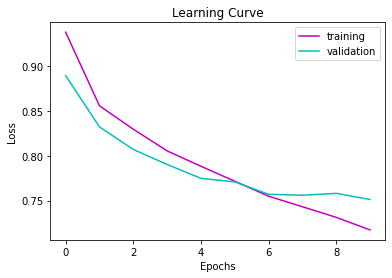

In [219]:
epochs = np.arange(0, 10).tolist()
Learning_Curve(epochs, train_epoch_losses, valid_epoch_losses)

In [220]:
y_training_df = pd.DataFrame(training_df['label'])
y_validation_df = pd.DataFrame(validation_df['label'])
y_train = torch.tensor(y_training_df.values)
y_valid = torch.tensor(y_validation_df.values)
y_valid_predicted_classes = ConvertToTensor(y_valid_pred_class, y_valid.shape)
y_valid_predictions = ConvertToTensor(y_valid_predictions, (y_valid.shape[0], num_classes))


In [221]:
calculate_metrics(y_valid, y_valid_predictions, y_valid_predicted_classes)

              precision    recall  f1-score   support

     class 0       0.74      0.76      0.75      1065
     class 1       0.51      0.28      0.36       296
     class 2       0.63      0.70      0.66       921

    accuracy                           0.67      2282
   macro avg       0.63      0.58      0.59      2282
weighted avg       0.66      0.67      0.66      2282

Precision score:	 0.6259821183489963
Recall score:		 0.5792967934673215
F1 score:		 0.5907037316110288


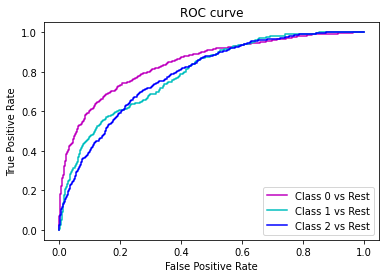

In [222]:
ROC_Curve(y_valid, y_valid_predictions)

### <font color='purple'>2</font>

In [ ]:
#Truncate the sentences to maximum 15 words
train_cut_encoded_sentences = Truncate_sentences(train_encoded_sentences, 15)
valid_cut_encoded_sentences = Truncate_sentences(valid_encoded_sentences, 15)
train_seq = train_cut_encoded_sentences  #list of tensors with diff dimensions
valid_seq = valid_cut_encoded_sentences

def InitializeDataloader(x_data, y_data, batch_size):
  
  #Separate features and targets and save in tensors
  sequence = x_data
  target = y_data
  #Pad the sequence
  padded_sentences = torch.nn.utils.rnn.pad_sequence(sequence, batch_first=True, padding_value=0)
  sentences_lengths = torch.LongTensor(list(map(len,sequence)))
  x = padded_sentences
  y_df = pd.DataFrame(target)
  y = torch.tensor(y_df.values)

  #Initialize dataloader
  dataset = torch.utils.data.TensorDataset(x, y)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

  return dataloader, sentences_lengths

In [ ]:
num_hidden = 80  #bigger overfits 
num_classes = 3
learning_rate = 0.0005
num_stacked_layers = 4 #maybe increase
input_size = embedding_weights.shape[0]    #size of the vocab of the trainign set
embedding_dimension = embedding_weights.shape[1]

# 28.921, 200, 3, [32437, 50], 50, 4
lstm_model = RNN(input_size, num_hidden, num_classes, embedding_weights, embedding_dimension, num_stacked_layers, dropout_prob = 0.0)
loss_function = nn.CrossEntropyLoss()
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.0003, weight_decay=1e-4)

#TRAIN AND EVALUATE THE MODEL
train_epoch_losses, valid_epoch_losses, y_valid_pred_class, y_valid_predictions = Train_Evaluate_TheModel(lstm_model, 10, 64, 
                                                                                                          loss_function, lstm_optimizer,
                                                                                                          train_seq, training_df['label'],
                                                                                                          valid_seq, validation_df['label'])

Epoch   0: Training Loss = 0.99559
Epoch   0: Validation Loss = 0.96013
Epoch   1: Training Loss = 0.92889
Epoch   1: Validation Loss = 0.92782
Epoch   2: Training Loss = 0.90003
Epoch   2: Validation Loss = 0.91025
Epoch   3: Training Loss = 0.87820
Epoch   3: Validation Loss = 0.89670
Epoch   4: Training Loss = 0.85843
Epoch   4: Validation Loss = 0.88715
Epoch   5: Training Loss = 0.84042
Epoch   5: Validation Loss = 0.88256
Epoch   6: Training Loss = 0.82377
Epoch   6: Validation Loss = 0.88151
Epoch   7: Training Loss = 0.80782
Epoch   7: Validation Loss = 0.88358
Epoch   8: Training Loss = 0.79155
Epoch   8: Validation Loss = 0.88933
Epoch   9: Training Loss = 0.77464
Epoch   9: Validation Loss = 0.89966


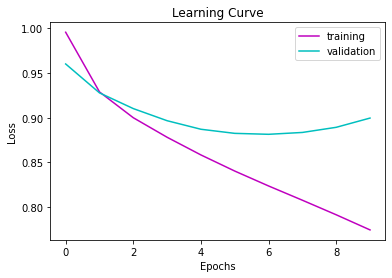

In [ ]:
epochs = np.arange(0, 10).tolist()
Learning_Curve(epochs, train_epoch_losses, valid_epoch_losses)

In [ ]:
y_training_df = pd.DataFrame(training_df['label'])
y_validation_df = pd.DataFrame(validation_df['label'])
y_train = torch.tensor(y_training_df.values)
y_valid = torch.tensor(y_validation_df.values)
y_valid_predicted_classes = ConvertToTensor(y_valid_pred_class, y_valid.shape)
y_valid_predictions = ConvertToTensor(y_valid_predictions, (y_valid.shape[0], num_classes))


In [ ]:
calculate_metrics(y_valid, y_valid_predictions, y_valid_predicted_classes)

              precision    recall  f1-score   support

     class 0       0.63      0.79      0.70      1065
     class 1       0.43      0.22      0.29       296
     class 2       0.59      0.51      0.55       921

    accuracy                           0.60      2282
   macro avg       0.55      0.51      0.51      2282
weighted avg       0.59      0.60      0.58      2282

Precision score:	 0.549465201843654
Recall score:		 0.5055793900061459
F1 score:		 0.5122526342274432


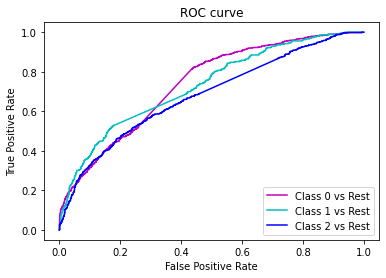

In [ ]:
ROC_Curve(y_valid, y_valid_predictions)

### <font color='purple'>3</font>

In [ ]:
#Truncate the sentences to maximum 15 words
train_cut_encoded_sentences = Truncate_sentences(train_encoded_sentences, 15)
valid_cut_encoded_sentences = Truncate_sentences(valid_encoded_sentences, 15)
train_seq = train_cut_encoded_sentences  #list of tensors with diff dimensions
valid_seq = valid_cut_encoded_sentences

def InitializeDataloader(x_data, y_data, batch_size):
  
  #Separate features and targets and save in tensors
  sequence = x_data
  target = y_data
  #Pad the sequence
  padded_sentences = torch.nn.utils.rnn.pad_sequence(sequence, batch_first=True, padding_value=0)
  sentences_lengths = torch.LongTensor(list(map(len,sequence)))
  x = padded_sentences
  y_df = pd.DataFrame(target)
  y = torch.tensor(y_df.values)

  #Initialize dataloader
  dataset = torch.utils.data.TensorDataset(x, y)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

  return dataloader, sentences_lengths

In [ ]:
num_hidden = 48  #bigger overfits 
num_classes = 3
learning_rate = 0.0005
num_stacked_layers = 2 #maybe increase
input_size = embedding_weights.shape[0]    #size of the vocab of the trainign set
embedding_dimension = embedding_weights.shape[1]

# 28.921, 200, 3, [32437, 50], 50, 4
lstm_model = RNN(input_size, num_hidden, num_classes, embedding_weights, embedding_dimension, num_stacked_layers, dropout_prob = 0.0)
loss_function = nn.CrossEntropyLoss()
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.0003, weight_decay=1e-4)

#TRAIN AND EVALUATE THE MODEL
train_epoch_losses, valid_epoch_losses, y_valid_pred_class, y_valid_predictions = Train_Evaluate_TheModel(lstm_model, 10, 64, 
                                                                                                          loss_function, lstm_optimizer,
                                                                                                          train_seq, training_df['label'],
                                                                                                          valid_seq, validation_df['label'])

Epoch   0: Training Loss = 0.98861
Epoch   0: Validation Loss = 0.95657
Epoch   1: Training Loss = 0.92279
Epoch   1: Validation Loss = 0.92562
Epoch   2: Training Loss = 0.89495
Epoch   2: Validation Loss = 0.91068
Epoch   3: Training Loss = 0.87580
Epoch   3: Validation Loss = 0.90067
Epoch   4: Training Loss = 0.85842
Epoch   4: Validation Loss = 0.89278
Epoch   5: Training Loss = 0.84215
Epoch   5: Validation Loss = 0.88706
Epoch   6: Training Loss = 0.82676
Epoch   6: Validation Loss = 0.88365
Epoch   7: Training Loss = 0.81169
Epoch   7: Validation Loss = 0.88266
Epoch   8: Training Loss = 0.79653
Epoch   8: Validation Loss = 0.88216
Epoch   9: Training Loss = 0.78132
Epoch   9: Validation Loss = 0.88311


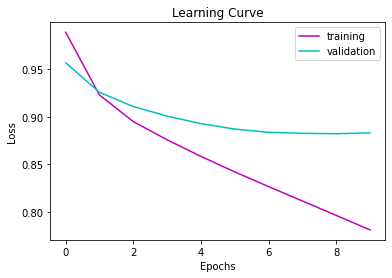

In [ ]:
epochs = np.arange(0, 10).tolist()
Learning_Curve(epochs, train_epoch_losses, valid_epoch_losses)

In [ ]:
y_training_df = pd.DataFrame(training_df['label'])
y_validation_df = pd.DataFrame(validation_df['label'])
y_train = torch.tensor(y_training_df.values)
y_valid = torch.tensor(y_validation_df.values)
y_valid_predicted_classes = ConvertToTensor(y_valid_pred_class, y_valid.shape)
y_valid_predictions = ConvertToTensor(y_valid_predictions, (y_valid.shape[0], num_classes))


In [ ]:
calculate_metrics(y_valid, y_valid_predictions, y_valid_predicted_classes)

              precision    recall  f1-score   support

     class 0       0.62      0.82      0.70      1065
     class 1       0.51      0.19      0.28       296
     class 2       0.61      0.50      0.55       921

    accuracy                           0.61      2282
   macro avg       0.58      0.50      0.51      2282
weighted avg       0.60      0.61      0.59      2282

Precision score:	 0.580681023207844
Recall score:		 0.5038250435598695
F1 score:		 0.5106143238017656


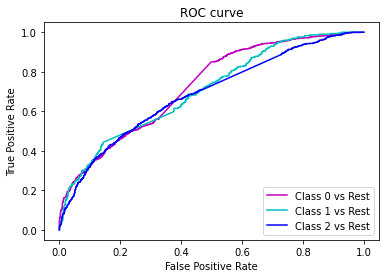

In [ ]:
ROC_Curve(y_valid, y_valid_predictions)

### <font color='purple'>4</font>

In [ ]:
#Truncate the sentences to maximum 15 words
train_cut_encoded_sentences = Truncate_sentences(train_encoded_sentences, 15)
valid_cut_encoded_sentences = Truncate_sentences(valid_encoded_sentences, 15)
train_seq = train_cut_encoded_sentences  #list of tensors with diff dimensions
valid_seq = valid_cut_encoded_sentences

def InitializeDataloader(x_data, y_data, batch_size):
  
  #Separate features and targets and save in tensors
  sequence = x_data
  target = y_data
  #Pad the sequence
  padded_sentences = torch.nn.utils.rnn.pad_sequence(sequence, batch_first=True, padding_value=0)
  sentences_lengths = torch.LongTensor(list(map(len,sequence)))
  x = padded_sentences
  y_df = pd.DataFrame(target)
  y = torch.tensor(y_df.values)

  #Initialize dataloader
  dataset = torch.utils.data.TensorDataset(x, y)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

  return dataloader, sentences_lengths

In [ ]:
num_hidden = 48  #bigger overfits 
num_classes = 3
learning_rate = 0.0005
num_stacked_layers = 2 #maybe increase
input_size = embedding_weights.shape[0]    #size of the vocab of the trainign set
embedding_dimension = embedding_weights.shape[1]

# 28.921, 200, 3, [32437, 50], 50, 4
lstm_model = RNN(input_size, num_hidden, num_classes, embedding_weights, embedding_dimension, num_stacked_layers, dropout_prob = 0.0)
loss_function = nn.CrossEntropyLoss()
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.0003, weight_decay=1e-4)

#TRAIN AND EVALUATE THE MODEL
train_epoch_losses, valid_epoch_losses, y_valid_pred_class, y_valid_predictions = Train_Evaluate_TheModel(lstm_model, 10, 32, 
                                                                                                          loss_function, lstm_optimizer,
                                                                                                          train_seq, training_df['label'],
                                                                                                          valid_seq, validation_df['label'])

Epoch   0: Training Loss = 0.97529
Epoch   0: Validation Loss = 0.94189
Epoch   1: Training Loss = 0.91240
Epoch   1: Validation Loss = 0.90937
Epoch   2: Training Loss = 0.88109
Epoch   2: Validation Loss = 0.89181
Epoch   3: Training Loss = 0.85881
Epoch   3: Validation Loss = 0.87926
Epoch   4: Training Loss = 0.83874
Epoch   4: Validation Loss = 0.86934
Epoch   5: Training Loss = 0.81951
Epoch   5: Validation Loss = 0.86294
Epoch   6: Training Loss = 0.80080
Epoch   6: Validation Loss = 0.86021
Epoch   7: Training Loss = 0.78237
Epoch   7: Validation Loss = 0.86077
Epoch   8: Training Loss = 0.76371
Epoch   8: Validation Loss = 0.86440
Epoch   9: Training Loss = 0.74477
Epoch   9: Validation Loss = 0.86914


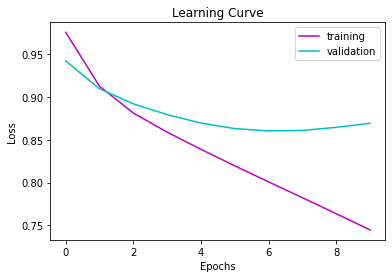

In [ ]:
epochs = np.arange(0, 10).tolist()
Learning_Curve(epochs, train_epoch_losses, valid_epoch_losses)

In [ ]:
y_training_df = pd.DataFrame(training_df['label'])
y_validation_df = pd.DataFrame(validation_df['label'])
y_train = torch.tensor(y_training_df.values)
y_valid = torch.tensor(y_validation_df.values)
y_valid_predicted_classes = ConvertToTensor(y_valid_pred_class, y_valid.shape)
y_valid_predictions = ConvertToTensor(y_valid_predictions, (y_valid.shape[0], num_classes))


In [ ]:
calculate_metrics(y_valid, y_valid_predictions, y_valid_predicted_classes)

              precision    recall  f1-score   support

     class 0       0.63      0.79      0.70      1065
     class 1       0.45      0.23      0.30       296
     class 2       0.61      0.52      0.56       921

    accuracy                           0.61      2282
   macro avg       0.56      0.51      0.52      2282
weighted avg       0.60      0.61      0.59      2282

Precision score:	 0.5628757286229632
Recall score:		 0.5141994910449285
F1 score:		 0.5222026905736694


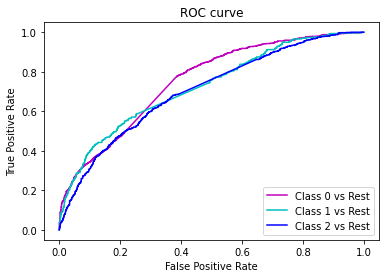

In [ ]:
ROC_Curve(y_valid, y_valid_predictions)

### <font color='purple'>5</font>

In [ ]:
#Truncate the sentences to maximum 15 words
train_cut_encoded_sentences = Truncate_sentences(train_encoded_sentences, 15)
valid_cut_encoded_sentences = Truncate_sentences(valid_encoded_sentences, 15)
train_seq = train_cut_encoded_sentences  #list of tensors with diff dimensions
valid_seq = valid_cut_encoded_sentences

def InitializeDataloader(x_data, y_data, batch_size):
  
  #Separate features and targets and save in tensors
  sequence = x_data
  target = y_data
  #Pad the sequence
  padded_sentences = torch.nn.utils.rnn.pad_sequence(sequence, batch_first=True, padding_value=0)
  sentences_lengths = torch.LongTensor(list(map(len,sequence)))
  x = padded_sentences
  y_df = pd.DataFrame(target)
  y = torch.tensor(y_df.values)

  #Initialize dataloader
  dataset = torch.utils.data.TensorDataset(x, y)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

  return dataloader, sentences_lengths

In [ ]:
num_hidden = 48  #bigger overfits 
num_classes = 3
learning_rate = 0.0005
num_stacked_layers = 2 #maybe increase
input_size = embedding_weights.shape[0]    #size of the vocab of the trainign set
embedding_dimension = embedding_weights.shape[1]

# 28.921, 200, 3, [32437, 50], 50, 4
lstm_model = RNN(input_size, num_hidden, num_classes, embedding_weights, embedding_dimension, num_stacked_layers)
loss_function = nn.CrossEntropyLoss()
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.0003, weight_decay=1e-4)

#TRAIN AND EVALUATE THE MODEL
train_epoch_losses, valid_epoch_losses, y_valid_pred_class, y_valid_predictions = Train_Evaluate_TheModel(lstm_model, 10, 32, 
                                                                                                          loss_function, lstm_optimizer,
                                                                                                          train_seq, training_df['label'],
                                                                                                          valid_seq, validation_df['label'])

Epoch   0: Training Loss = 0.97711
Epoch   0: Validation Loss = 0.94508
Epoch   1: Training Loss = 0.91785
Epoch   1: Validation Loss = 0.91853
Epoch   2: Training Loss = 0.88665
Epoch   2: Validation Loss = 0.90068
Epoch   3: Training Loss = 0.86462
Epoch   3: Validation Loss = 0.88842
Epoch   4: Training Loss = 0.84492
Epoch   4: Validation Loss = 0.87526
Epoch   5: Training Loss = 0.82834
Epoch   5: Validation Loss = 0.86971
Epoch   6: Training Loss = 0.81194
Epoch   6: Validation Loss = 0.86908
Epoch   7: Training Loss = 0.79645
Epoch   7: Validation Loss = 0.86802
Epoch   8: Training Loss = 0.78171
Epoch   8: Validation Loss = 0.87150
Epoch   9: Training Loss = 0.76701
Epoch   9: Validation Loss = 0.87599


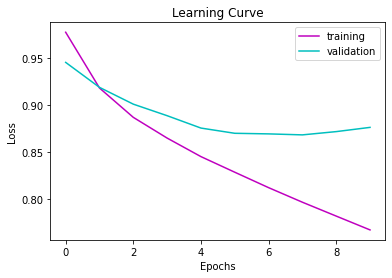

In [ ]:
epochs = np.arange(0, 10).tolist()
Learning_Curve(epochs, train_epoch_losses, valid_epoch_losses)

In [ ]:
y_training_df = pd.DataFrame(training_df['label'])
y_validation_df = pd.DataFrame(validation_df['label'])
y_train = torch.tensor(y_training_df.values)
y_valid = torch.tensor(y_validation_df.values)
y_valid_predicted_classes = ConvertToTensor(y_valid_pred_class, y_valid.shape)
y_valid_predictions = ConvertToTensor(y_valid_predictions, (y_valid.shape[0], num_classes))


In [ ]:
calculate_metrics(y_valid, y_valid_predictions, y_valid_predicted_classes)

              precision    recall  f1-score   support

     class 0       0.63      0.80      0.70      1065
     class 1       0.44      0.20      0.27       296
     class 2       0.60      0.51      0.55       921

    accuracy                           0.61      2282
   macro avg       0.55      0.50      0.51      2282
weighted avg       0.59      0.61      0.59      2282

Precision score:	 0.5534066262550148
Recall score:		 0.5025956749978405
F1 score:		 0.50829494155775


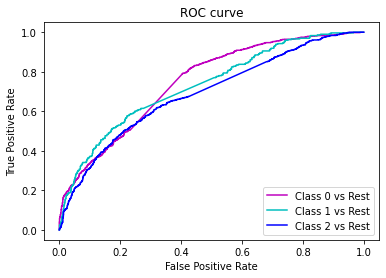

In [ ]:
ROC_Curve(y_valid, y_valid_predictions)

## <font color='purple'>GRU</font>

### <font color='purple'>1</font>

In [ ]:
#Truncate the sentences to maximum 20 words
train_cut_encoded_sentences = Truncate_sentences(train_encoded_sentences, 20)
valid_cut_encoded_sentences = Truncate_sentences(valid_encoded_sentences, 20)
train_seq = train_cut_encoded_sentences  #list of tensors with diff dimensions
valid_seq = valid_cut_encoded_sentences

def InitializeDataloader(x_data, y_data, batch_size):
  
  #Separate features and targets and save in tensors
  sequence = x_data
  target = y_data
  #Pad the sequence
  padded_sentences = torch.nn.utils.rnn.pad_sequence(sequence, batch_first=True, padding_value=0)
  sentences_lengths = torch.LongTensor(list(map(len,sequence)))
  x = padded_sentences
  y_df = pd.DataFrame(target)
  y = torch.tensor(y_df.values)

  #Initialize dataloader
  dataset = torch.utils.data.TensorDataset(x, y)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

  return dataloader, sentences_lengths

In [ ]:
num_hidden = 128  #bigger overfits 
num_classes = 3
learning_rate = 0.0005
num_stacked_layers = 4 #maybe increase
input_size = embedding_weights.shape[0]    #size of the vocab of the trainign set
embedding_dimension = embedding_weights.shape[1]

# 28.921, 200, 3, [32437, 50], 50, 4
gru_model = RNN(input_size, num_hidden, num_classes, embedding_weights, embedding_dimension, num_stacked_layers, cell_type='GRU')
loss_function = nn.CrossEntropyLoss()
gru_optimizer = optim.Adam(gru_model.parameters(), lr=0.0003, weight_decay=1e-4)

#TRAIN AND EVALUATE THE MODEL
train_epoch_losses, valid_epoch_losses, y_valid_pred_class, y_valid_predictions = Train_Evaluate_TheModel(gru_model, 10, 64, 
                                                                                                          loss_function, gru_optimizer, 
                                                                                                          train_seq, training_df['label'],
                                                                                                          valid_seq, validation_df['label'])

Epoch   0: Training Loss = 1.03288
Epoch   0: Validation Loss = 1.00271
Epoch   1: Training Loss = 0.98195
Epoch   1: Validation Loss = 0.97785
Epoch   2: Training Loss = 0.95332
Epoch   2: Validation Loss = 0.96186
Epoch   3: Training Loss = 0.93172
Epoch   3: Validation Loss = 0.95072
Epoch   4: Training Loss = 0.91300
Epoch   4: Validation Loss = 0.94401
Epoch   5: Training Loss = 0.89543
Epoch   5: Validation Loss = 0.93713
Epoch   6: Training Loss = 0.87686
Epoch   6: Validation Loss = 0.94041
Epoch   7: Training Loss = 0.85990
Epoch   7: Validation Loss = 0.94444
Epoch   8: Training Loss = 0.84266
Epoch   8: Validation Loss = 0.96008
Epoch   9: Training Loss = 0.82610
Epoch   9: Validation Loss = 0.97994


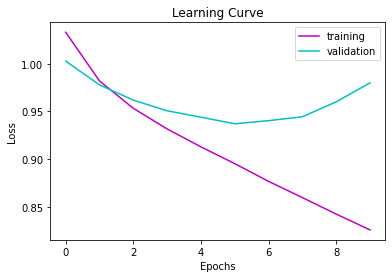

In [ ]:
epochs = np.arange(0, 10).tolist()
Learning_Curve(epochs, train_epoch_losses, valid_epoch_losses)

In [ ]:
y_training_df = pd.DataFrame(training_df['label'])
y_validation_df = pd.DataFrame(validation_df['label'])
y_train = torch.tensor(y_training_df.values)
y_valid = torch.tensor(y_validation_df.values)
y_valid_predicted_classes = ConvertToTensor(y_valid_pred_class, y_valid.shape)
y_valid_predictions = ConvertToTensor(y_valid_predictions, (y_valid.shape[0], num_classes))


In [ ]:
calculate_metrics(y_valid, y_valid_predictions, y_valid_predicted_classes)

              precision    recall  f1-score   support

     class 0       0.55      0.88      0.68      1065
     class 1       0.40      0.22      0.28       296
     class 2       0.61      0.29      0.39       921

    accuracy                           0.55      2282
   macro avg       0.52      0.46      0.45      2282
weighted avg       0.56      0.55      0.51      2282

Precision score:	 0.5223663816384213
Recall score:		 0.4604033691442509
F1 score:		 0.45029111283023604


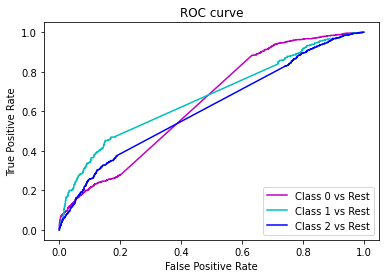

In [ ]:
ROC_Curve(y_valid, y_valid_predictions)

### <font color='purple'>2</font>

In [ ]:
#Truncate the sentences to maximum 15 words
train_cut_encoded_sentences = Truncate_sentences(train_encoded_sentences, 15)
valid_cut_encoded_sentences = Truncate_sentences(valid_encoded_sentences, 15)
train_seq = train_cut_encoded_sentences  #list of tensors with diff dimensions
valid_seq = valid_cut_encoded_sentences

def InitializeDataloader(x_data, y_data, batch_size):
  
  #Separate features and targets and save in tensors
  sequence = x_data
  target = y_data
  #Pad the sequence
  padded_sentences = torch.nn.utils.rnn.pad_sequence(sequence, batch_first=True, padding_value=0)
  sentences_lengths = torch.LongTensor(list(map(len,sequence)))
  x = padded_sentences
  y_df = pd.DataFrame(target)
  y = torch.tensor(y_df.values)

  #Initialize dataloader
  dataset = torch.utils.data.TensorDataset(x, y)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

  return dataloader, sentences_lengths

In [ ]:
num_hidden = 80  #bigger overfits 
num_classes = 3
learning_rate = 0.0005
num_stacked_layers = 4 #maybe increase
input_size = embedding_weights.shape[0]    #size of the vocab of the trainign set
embedding_dimension = embedding_weights.shape[1]

# 28.921, 200, 3, [32437, 50], 50, 4
gru_model = RNN(input_size, num_hidden, num_classes, embedding_weights, embedding_dimension, num_stacked_layers, cell_type='GRU', dropout_prob = 0.0)
loss_function = nn.CrossEntropyLoss()
gru_optimizer = optim.Adam(gru_model.parameters(), lr=0.0003, weight_decay=1e-4)

#TRAIN AND EVALUATE THE MODEL
train_epoch_losses, valid_epoch_losses, y_valid_pred_class, y_valid_predictions = Train_Evaluate_TheModel(gru_model, 10, 64, 
                                                                                                          loss_function, gru_optimizer, 
                                                                                                          train_seq, training_df['label'],
                                                                                                          valid_seq, validation_df['label'])

Epoch   0: Training Loss = 0.97111
Epoch   0: Validation Loss = 0.94080
Epoch   1: Training Loss = 0.91018
Epoch   1: Validation Loss = 0.91490
Epoch   2: Training Loss = 0.88388
Epoch   2: Validation Loss = 0.90001
Epoch   3: Training Loss = 0.86342
Epoch   3: Validation Loss = 0.88954
Epoch   4: Training Loss = 0.84446
Epoch   4: Validation Loss = 0.88022
Epoch   5: Training Loss = 0.82589
Epoch   5: Validation Loss = 0.87280
Epoch   6: Training Loss = 0.80766
Epoch   6: Validation Loss = 0.86897
Epoch   7: Training Loss = 0.78967
Epoch   7: Validation Loss = 0.86914
Epoch   8: Training Loss = 0.77155
Epoch   8: Validation Loss = 0.87331
Epoch   9: Training Loss = 0.75296
Epoch   9: Validation Loss = 0.88142


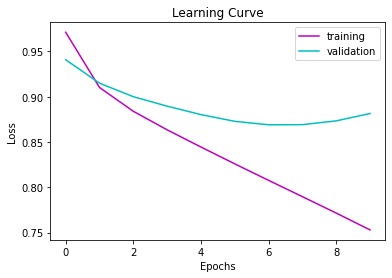

In [ ]:
epochs = np.arange(0, 10).tolist()
Learning_Curve(epochs, train_epoch_losses, valid_epoch_losses)

In [ ]:
y_training_df = pd.DataFrame(training_df['label'])
y_validation_df = pd.DataFrame(validation_df['label'])
y_train = torch.tensor(y_training_df.values)
y_valid = torch.tensor(y_validation_df.values)
y_valid_predicted_classes = ConvertToTensor(y_valid_pred_class, y_valid.shape)
y_valid_predictions = ConvertToTensor(y_valid_predictions, (y_valid.shape[0], num_classes))


In [ ]:
calculate_metrics(y_valid, y_valid_predictions, y_valid_predicted_classes)

              precision    recall  f1-score   support

     class 0       0.63      0.79      0.70      1065
     class 1       0.44      0.24      0.31       296
     class 2       0.60      0.51      0.55       921

    accuracy                           0.61      2282
   macro avg       0.56      0.52      0.52      2282
weighted avg       0.59      0.61      0.59      2282

Precision score:	 0.5575493236758091
Recall score:		 0.5158085920025637
F1 score:		 0.5232485701060673


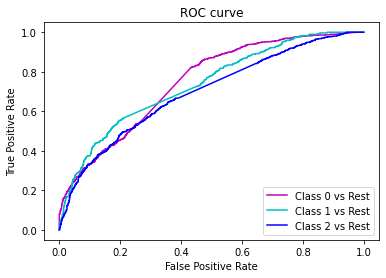

In [ ]:
ROC_Curve(y_valid, y_valid_predictions)

### <font color='purple'>3</font>

In [ ]:
#Truncate the sentences to maximum 15 words
train_cut_encoded_sentences = Truncate_sentences(train_encoded_sentences, 15)
valid_cut_encoded_sentences = Truncate_sentences(valid_encoded_sentences, 15)
train_seq = train_cut_encoded_sentences  #list of tensors with diff dimensions
valid_seq = valid_cut_encoded_sentences

def InitializeDataloader(x_data, y_data, batch_size):
  
  #Separate features and targets and save in tensors
  sequence = x_data
  target = y_data
  #Pad the sequence
  padded_sentences = torch.nn.utils.rnn.pad_sequence(sequence, batch_first=True, padding_value=0)
  sentences_lengths = torch.LongTensor(list(map(len,sequence)))
  x = padded_sentences
  y_df = pd.DataFrame(target)
  y = torch.tensor(y_df.values)

  #Initialize dataloader
  dataset = torch.utils.data.TensorDataset(x, y)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

  return dataloader, sentences_lengths

In [ ]:
num_hidden = 48  #bigger overfits 
num_classes = 3
learning_rate = 0.0005
num_stacked_layers = 2 #maybe increase
input_size = embedding_weights.shape[0]    #size of the vocab of the trainign set
embedding_dimension = embedding_weights.shape[1]

# 28.921, 200, 3, [32437, 50], 50, 4
gru_model = RNN(input_size, num_hidden, num_classes, embedding_weights, embedding_dimension, num_stacked_layers, cell_type='GRU', dropout_prob = 0.0)
loss_function = nn.CrossEntropyLoss()
gru_optimizer = optim.Adam(gru_model.parameters(), lr=0.0003, weight_decay=1e-4)

#TRAIN AND EVALUATE THE MODEL
train_epoch_losses, valid_epoch_losses, y_valid_pred_class, y_valid_predictions = Train_Evaluate_TheModel(gru_model, 10, 64, 
                                                                                                          loss_function, gru_optimizer, 
                                                                                                          train_seq, training_df['label'],
                                                                                                          valid_seq, validation_df['label'])

Epoch   0: Training Loss = 0.99550
Epoch   0: Validation Loss = 0.95809
Epoch   1: Training Loss = 0.93043
Epoch   1: Validation Loss = 0.93065
Epoch   2: Training Loss = 0.89938
Epoch   2: Validation Loss = 0.91279
Epoch   3: Training Loss = 0.87818
Epoch   3: Validation Loss = 0.90162
Epoch   4: Training Loss = 0.85939
Epoch   4: Validation Loss = 0.89287
Epoch   5: Training Loss = 0.84151
Epoch   5: Validation Loss = 0.88506
Epoch   6: Training Loss = 0.82445
Epoch   6: Validation Loss = 0.87905
Epoch   7: Training Loss = 0.80815
Epoch   7: Validation Loss = 0.87497
Epoch   8: Training Loss = 0.79261
Epoch   8: Validation Loss = 0.87275
Epoch   9: Training Loss = 0.77774
Epoch   9: Validation Loss = 0.87244


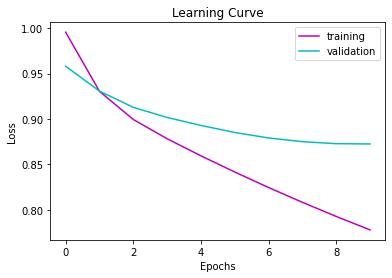

In [ ]:
epochs = np.arange(0, 10).tolist()
Learning_Curve(epochs, train_epoch_losses, valid_epoch_losses)

In [ ]:
y_training_df = pd.DataFrame(training_df['label'])
y_validation_df = pd.DataFrame(validation_df['label'])
y_train = torch.tensor(y_training_df.values)
y_valid = torch.tensor(y_validation_df.values)
y_valid_predicted_classes = ConvertToTensor(y_valid_pred_class, y_valid.shape)
y_valid_predictions = ConvertToTensor(y_valid_predictions, (y_valid.shape[0], num_classes))


In [ ]:
calculate_metrics(y_valid, y_valid_predictions, y_valid_predicted_classes)

              precision    recall  f1-score   support

     class 0       0.63      0.82      0.71      1065
     class 1       0.54      0.17      0.26       296
     class 2       0.60      0.53      0.56       921

    accuracy                           0.62      2282
   macro avg       0.59      0.50      0.51      2282
weighted avg       0.61      0.62      0.59      2282

Precision score:	 0.590330962322814
Recall score:		 0.5048155303075704
F1 score:		 0.5105226925910635


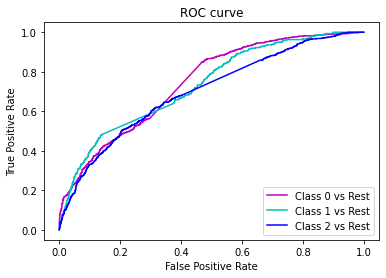

In [ ]:
ROC_Curve(y_valid, y_valid_predictions)

### <font color='purple'>4</font>

In [ ]:
#Truncate the sentences to maximum 15 words
train_cut_encoded_sentences = Truncate_sentences(train_encoded_sentences, 15)
valid_cut_encoded_sentences = Truncate_sentences(valid_encoded_sentences, 15)
train_seq = train_cut_encoded_sentences  #list of tensors with diff dimensions
valid_seq = valid_cut_encoded_sentences

def InitializeDataloader(x_data, y_data, batch_size):
  
  #Separate features and targets and save in tensors
  sequence = x_data
  target = y_data
  #Pad the sequence
  padded_sentences = torch.nn.utils.rnn.pad_sequence(sequence, batch_first=True, padding_value=0)
  sentences_lengths = torch.LongTensor(list(map(len,sequence)))
  x = padded_sentences
  y_df = pd.DataFrame(target)
  y = torch.tensor(y_df.values)

  #Initialize dataloader
  dataset = torch.utils.data.TensorDataset(x, y)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

  return dataloader, sentences_lengths

In [ ]:
num_hidden = 48  #bigger overfits 
num_classes = 3
learning_rate = 0.0005
num_stacked_layers = 2 #maybe increase
input_size = embedding_weights.shape[0]    #size of the vocab of the trainign set
embedding_dimension = embedding_weights.shape[1]

# 28.921, 200, 3, [32437, 50], 50, 4
gru_model = RNN(input_size, num_hidden, num_classes, embedding_weights, embedding_dimension, num_stacked_layers, cell_type='GRU', dropout_prob = 0.0)
loss_function = nn.CrossEntropyLoss()
gru_optimizer = optim.Adam(gru_model.parameters(), lr=0.0003, weight_decay=1e-4)

#TRAIN AND EVALUATE THE MODEL
train_epoch_losses, valid_epoch_losses, y_valid_pred_class, y_valid_predictions = Train_Evaluate_TheModel(gru_model, 10, 32, 
                                                                                                          loss_function, gru_optimizer, 
                                                                                                          train_seq, training_df['label'],
                                                                                                          valid_seq, validation_df['label'])

Epoch   0: Training Loss = 0.97831
Epoch   0: Validation Loss = 0.93850
Epoch   1: Training Loss = 0.91328
Epoch   1: Validation Loss = 0.90791
Epoch   2: Training Loss = 0.88070
Epoch   2: Validation Loss = 0.89067
Epoch   3: Training Loss = 0.85571
Epoch   3: Validation Loss = 0.87774
Epoch   4: Training Loss = 0.83346
Epoch   4: Validation Loss = 0.86784
Epoch   5: Training Loss = 0.81298
Epoch   5: Validation Loss = 0.86170
Epoch   6: Training Loss = 0.79386
Epoch   6: Validation Loss = 0.85954
Epoch   7: Training Loss = 0.77575
Epoch   7: Validation Loss = 0.86095
Epoch   8: Training Loss = 0.75833
Epoch   8: Validation Loss = 0.86567
Epoch   9: Training Loss = 0.74128
Epoch   9: Validation Loss = 0.87358


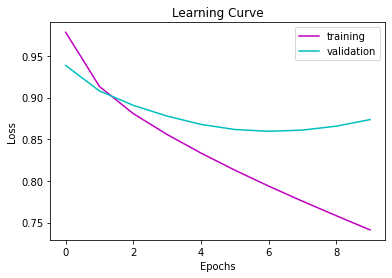

In [ ]:
epochs = np.arange(0, 10).tolist()
Learning_Curve(epochs, train_epoch_losses, valid_epoch_losses)

In [ ]:
y_training_df = pd.DataFrame(training_df['label'])
y_validation_df = pd.DataFrame(validation_df['label'])
y_train = torch.tensor(y_training_df.values)
y_valid = torch.tensor(y_validation_df.values)
y_valid_predicted_classes = ConvertToTensor(y_valid_pred_class, y_valid.shape)
y_valid_predictions = ConvertToTensor(y_valid_predictions, (y_valid.shape[0], num_classes))


In [ ]:
calculate_metrics(y_valid, y_valid_predictions, y_valid_predicted_classes)

              precision    recall  f1-score   support

     class 0       0.64      0.77      0.70      1065
     class 1       0.53      0.25      0.34       296
     class 2       0.60      0.56      0.58       921

    accuracy                           0.62      2282
   macro avg       0.59      0.53      0.54      2282
weighted avg       0.61      0.62      0.60      2282

Precision score:	 0.5909013500207271
Recall score:		 0.5263356040813948
F1 score:		 0.5388881056286133


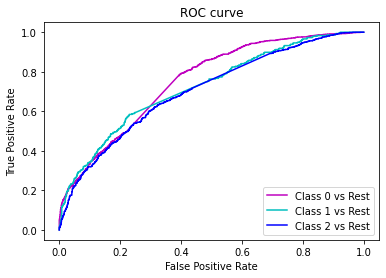

In [ ]:
ROC_Curve(y_valid, y_valid_predictions)

### <font color='purple'>5</font>

In [ ]:
#Truncate the sentences to maximum 15 words
train_cut_encoded_sentences = Truncate_sentences(train_encoded_sentences, 15)
valid_cut_encoded_sentences = Truncate_sentences(valid_encoded_sentences, 15)
train_seq = train_cut_encoded_sentences  #list of tensors with diff dimensions
valid_seq = valid_cut_encoded_sentences

def InitializeDataloader(x_data, y_data, batch_size):
  
  #Separate features and targets and save in tensors
  sequence = x_data
  target = y_data
  #Pad the sequence
  padded_sentences = torch.nn.utils.rnn.pad_sequence(sequence, batch_first=True, padding_value=0)
  sentences_lengths = torch.LongTensor(list(map(len,sequence)))
  x = padded_sentences
  y_df = pd.DataFrame(target)
  y = torch.tensor(y_df.values)

  #Initialize dataloader
  dataset = torch.utils.data.TensorDataset(x, y)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

  return dataloader, sentences_lengths

In [ ]:
num_hidden = 48  #bigger overfits 
num_classes = 3
learning_rate = 0.0005
num_stacked_layers = 2 #maybe increase
input_size = embedding_weights.shape[0]    #size of the vocab of the trainign set
embedding_dimension = embedding_weights.shape[1]

# 28.921, 200, 3, [32437, 50], 50, 4
gru_model = RNN(input_size, num_hidden, num_classes, embedding_weights, embedding_dimension, num_stacked_layers, cell_type='GRU')
loss_function = nn.CrossEntropyLoss()
gru_optimizer = optim.Adam(gru_model.parameters(), lr=0.0003, weight_decay=1e-4)

#TRAIN AND EVALUATE THE MODEL
train_epoch_losses, valid_epoch_losses, y_valid_pred_class, y_valid_predictions = Train_Evaluate_TheModel(gru_model, 10, 32, 
                                                                                                          loss_function, gru_optimizer, 
                                                                                                          train_seq, training_df['label'],
                                                                                                          valid_seq, validation_df['label'])

Epoch   0: Training Loss = 0.96987
Epoch   0: Validation Loss = 0.93286
Epoch   1: Training Loss = 0.90713
Epoch   1: Validation Loss = 0.90396
Epoch   2: Training Loss = 0.87663
Epoch   2: Validation Loss = 0.88350
Epoch   3: Training Loss = 0.85357
Epoch   3: Validation Loss = 0.87006
Epoch   4: Training Loss = 0.83291
Epoch   4: Validation Loss = 0.85919
Epoch   5: Training Loss = 0.81557
Epoch   5: Validation Loss = 0.85407
Epoch   6: Training Loss = 0.79960
Epoch   6: Validation Loss = 0.85245
Epoch   7: Training Loss = 0.78224
Epoch   7: Validation Loss = 0.85158
Epoch   8: Training Loss = 0.76790
Epoch   8: Validation Loss = 0.85622
Epoch   9: Training Loss = 0.75445
Epoch   9: Validation Loss = 0.85852


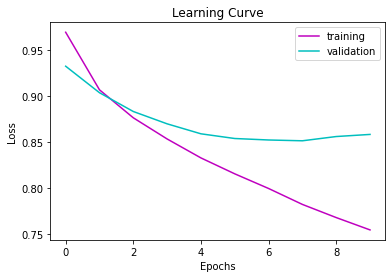

In [ ]:
epochs = np.arange(0, 10).tolist()
Learning_Curve(epochs, train_epoch_losses, valid_epoch_losses)

In [ ]:
y_training_df = pd.DataFrame(training_df['label'])
y_validation_df = pd.DataFrame(validation_df['label'])
y_train = torch.tensor(y_training_df.values)
y_valid = torch.tensor(y_validation_df.values)
y_valid_predicted_classes = ConvertToTensor(y_valid_pred_class, y_valid.shape)
y_valid_predictions = ConvertToTensor(y_valid_predictions, (y_valid.shape[0], num_classes))


In [ ]:
calculate_metrics(y_valid, y_valid_predictions, y_valid_predicted_classes)

              precision    recall  f1-score   support

     class 0       0.63      0.76      0.69      1065
     class 1       0.55      0.19      0.28       296
     class 2       0.59      0.58      0.58       921

    accuracy                           0.61      2282
   macro avg       0.59      0.51      0.52      2282
weighted avg       0.60      0.61      0.59      2282

Precision score:	 0.590517033826893
Recall score:		 0.50984378997523
F1 score:		 0.5197908699262622


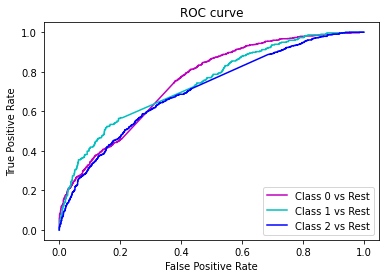

In [ ]:
ROC_Curve(y_valid, y_valid_predictions)

# <font color='magenta'>RUN THE LSTM MODEL (example) </font>

In [272]:
num_hidden = 64  #bigger overfits 
num_classes = 3
learning_rate = 0.0005
num_stacked_layers = 3 #maybe increase
input_size = embedding_weights.shape[0]    #size of the vocab of the trainign set
embedding_dimension = embedding_weights.shape[1]

# 32437, 200, 3, [32437, 200], 200, 2
lstm_model = RNN(input_size, num_hidden, num_classes, embedding_weights, embedding_dimension, num_stacked_layers)
loss_function = nn.CrossEntropyLoss()
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.0004, weight_decay=1e-4)

#TRAIN AND EVALUATE THE MODEL
train_epoch_losses, valid_epoch_losses, y_valid_pred_class, y_valid_predictions = Train_Evaluate_TheModel(lstm_model, 10, 32, 
                                                                                                          loss_function, lstm_optimizer,
                                                                                                          train_seq, training_df['label'],
                                                                                                          valid_seq, validation_df['label'])

Epoch   0: Training Loss = 0.92505
Epoch   0: Validation Loss = 0.88525
Epoch   1: Training Loss = 0.84733
Epoch   1: Validation Loss = 0.81524
Epoch   2: Training Loss = 0.81636
Epoch   2: Validation Loss = 0.79114
Epoch   3: Training Loss = 0.79647
Epoch   3: Validation Loss = 0.77442
Epoch   4: Training Loss = 0.77366
Epoch   4: Validation Loss = 0.75982
Epoch   5: Training Loss = 0.75363
Epoch   5: Validation Loss = 0.74432
Epoch   6: Training Loss = 0.73883
Epoch   6: Validation Loss = 0.73927
Epoch   7: Training Loss = 0.72657
Epoch   7: Validation Loss = 0.73404
Epoch   8: Training Loss = 0.70849
Epoch   8: Validation Loss = 0.72338
Epoch   9: Training Loss = 0.69983
Epoch   9: Validation Loss = 0.72767


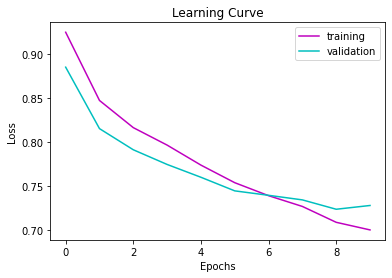

In [273]:
epochs = np.arange(0, 10).tolist()
Learning_Curve(epochs, train_epoch_losses, valid_epoch_losses)

In [274]:
y_training_df = pd.DataFrame(training_df['label'])
y_validation_df = pd.DataFrame(validation_df['label'])
y_train = torch.tensor(y_training_df.values)
y_valid = torch.tensor(y_validation_df.values)
y_valid_predicted_classes = ConvertToTensor(y_valid_pred_class, y_valid.shape)
y_valid_predictions = ConvertToTensor(y_valid_predictions, (y_valid.shape[0], num_classes))


In [275]:
calculate_metrics(y_valid, y_valid_predictions, y_valid_predicted_classes)

              precision    recall  f1-score   support

     class 0       0.79      0.72      0.75      1065
     class 1       0.48      0.32      0.38       296
     class 2       0.63      0.75      0.68       921

    accuracy                           0.68      2282
   macro avg       0.63      0.60      0.61      2282
weighted avg       0.68      0.68      0.68      2282

Precision score:	 0.6296749565654538
Recall score:		 0.5977610392426652
F1 score:		 0.6062617175636906


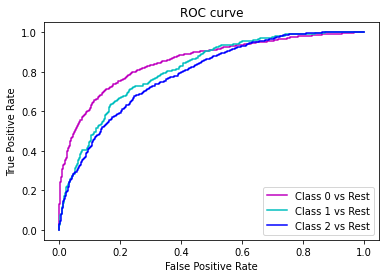

In [276]:
ROC_Curve(y_valid, y_valid_predictions)